# SAX Quick Start

Let's go over the core functionality of SAX.

## Environment variables

SAX is based on JAX… here are some useful environment variables for working with JAX:

In [1]:
# select float32 or float64 as default dtype
%env JAX_ENABLE_X64=0

# select cpu or gpu
%env JAX_PLATFORM_NAME=cpu

# set custom CUDA location for gpu:
%env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda

# Using GPU?
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)



env: JAX_ENABLE_X64=0
env: JAX_PLATFORM_NAME=cpu
env: XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/lib/cuda
cpu


## Imports

In [2]:
import tqdm  # progress bars
import matplotlib.pyplot as plt  # plotting

import sax
import jax
import jax.numpy as jnp
import jax.experimental.optimizers as opt


/home/jmatres/miniconda3/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Scatter dictionaries

The core datastructure for specifying scatter parameters in SAX is a dictionary… more specifically a dictionary which maps a port combination (2-tuple) to a scatter parameter (or an array of scatter parameters when considering multiple wavelengths for example). Such a specific dictionary mapping is called ann SDict in SAX (SDict ≈ Dict[Tuple[str,str], float]).

Dictionaries are in fact much better suited for characterizing S-parameters than, say, (jax-)numpy arrays due to the inherent sparse nature of scatter parameters. Moreover, dictonaries allow for string indexing, which makes them much more pleasant to use in this context. Let’s for example create an SDict for a 50/50 coupler:

```
in1          out1
   \        /
    ========
   /        \
in0          out0
```

In [3]:
coupling = 0.5
kappa = coupling ** 0.5
tau = (1 - coupling) ** 0.5
coupler = {
    ("in0", "out0"): tau,
    ("out0", "in0"): tau,
    ("in0", "out1"): 1j * kappa,
    ("out1", "in0"): 1j * kappa,
    ("in1", "out0"): 1j * kappa,
    ("out0", "in1"): 1j * kappa,
    ("in1", "out1"): tau,
    ("out1", "in1"): tau,
}
coupler

{('in0', 'out0'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('out1', 'in0'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out1', 'in1'): 0.7071067811865476}

Only the non-zero port combinations need to be specified. Any non-existent port-combination (for example ("in0", "in1")) is considered to be zero by SAX.


Obviously, it can still be tedious to specify every port in the circuit manually. SAX therefore offers the reciprocal function, which auto-fills the reverse connection if the forward connection exist. For example:

In [4]:
coupler = sax.reciprocal(
    {
        ("in0", "out0"): tau,
        ("in0", "out1"): 1j * kappa,
        ("in1", "out0"): 1j * kappa,
        ("in1", "out1"): tau,
    }
)

coupler

{('in0', 'out0'): 0.7071067811865476,
 ('in0', 'out1'): 0.7071067811865476j,
 ('in1', 'out0'): 0.7071067811865476j,
 ('in1', 'out1'): 0.7071067811865476,
 ('out0', 'in0'): 0.7071067811865476,
 ('out1', 'in0'): 0.7071067811865476j,
 ('out0', 'in1'): 0.7071067811865476j,
 ('out1', 'in1'): 0.7071067811865476}

## Parametrized Models

Constructing such an SDict is easy, however, usually we’re more interested in having parametrized models for our components. To parametrize the coupler SDict, just wrap it in a function to obtain a SAX Model, which is a keyword-only function mapping to an SDict:

In [5]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling ** 0.5
    tau = (1 - coupling) ** 0.5
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return sdict


coupler(coupling=0.3)

{('in0', 'out0'): 0.8366600265340756,
 ('in0', 'out1'): 0.5477225575051661j,
 ('in1', 'out0'): 0.5477225575051661j,
 ('in1', 'out1'): 0.8366600265340756,
 ('out0', 'in0'): 0.8366600265340756,
 ('out1', 'in0'): 0.5477225575051661j,
 ('out0', 'in1'): 0.5477225575051661j,
 ('out1', 'in1'): 0.8366600265340756}

We can define a waveguide in much the same way:

In [7]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict

That’s pretty straightforward. Let’s now move on to parametrized circuits:

## Circuit Models

Existing models can now be combined into a circuit using `sax.circuit`, which basically creates a new `Model` function:

In [8]:
mzi = sax.circuit(
    instances={
        "lft": coupler,
        "top": waveguide,
        "btm": waveguide,
        "rgt": coupler,
    },
    connections={
        "lft:out0": "btm:in0",
        "btm:out0": "rgt:in0",
        "lft:out1": "top:in0",
        "top:out0": "rgt:in1",
    },
    ports={
        "in0": "lft:in0",
        "in1": "lft:in1",
        "out0": "rgt:out0",
        "out1": "rgt:out1",
    },
)

In [9]:
mzi?

Signature:
mzi(
    *,
    lft={'coupling': DeviceArray(0.5, dtype=float32)},
    top={'wl': DeviceArray(1.55, dtype=float32), 'wl0': DeviceArray(1.55, dtype=float32), 'neff': DeviceArray(2.34, dtype=float32), 'ng': DeviceArray(3.4, dtype=float32), 'length': DeviceArray(10., dtype=float32), 'loss': DeviceArray(0., dtype=float32)},
    btm={'wl': DeviceArray(1.55, dtype=float32), 'wl0': DeviceArray(1.55, dtype=float32), 'neff': DeviceArray(2.34, dtype=float32), 'ng': DeviceArray(3.4, dtype=float32), 'length': DeviceArray(10., dtype=float32), 'loss': DeviceArray(0., dtype=float32)},
    rgt={'coupling': DeviceArray(0.5, dtype=float32)},
) -> Dict[Tuple[str, str], Union[complex, float, jax._src.numpy.lax_numpy.ndarray, numpy.ndarray]]
Docstring: <no docstring>
File:      ~/miniconda3/lib/python3.9/site-packages/sax/core.py
Type:      function


The `circuit` function just creates a similar function as we created for the waveguide and the coupler, but in stead of taking parameters directly it takes parameter dictionaries for each of the instances in the circuit. The keys in these parameter dictionaries should correspond to the keyword arguments of each individual subcomponent.


Let’s now do a simulation for the MZI we just constructed:

In [10]:
mzi()

{('in0', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0', 'out0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0',
  'out1'): DeviceArray(-0.5712662+0.82076484j, dtype=complex64, weak_type=True),
 ('in1',
  'out0'): DeviceArray(-0.5712662+0.82076484j, dtype=complex64, weak_type=True),
 ('in1', 'out1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out0', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out0',
  'in1'): DeviceArray(-0.5712662+0.82076484j, dtype=complex64, weak_type=True),
 ('out0', 'out0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out0', 'out1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out1',
  'in0'): DeviceArray(-0.5712662+0.82076484j, dtype=complex64, weak_type=T

Or in the case we want an MZI with different arm lengths:

In [11]:
mzi(top={"length": 25.0}, btm={"length": 15.0})

{('in0', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0',
  'out0'): DeviceArray(-0.28073022+0.10397261j, dtype=complex64, weak_type=True),
 ('in0',
  'out1'): DeviceArray(0.89474374-0.3313817j, dtype=complex64, weak_type=True),
 ('in1',
  'out0'): DeviceArray(0.89474374-0.3313817j, dtype=complex64, weak_type=True),
 ('in1',
  'out1'): DeviceArray(0.28073022-0.10397261j, dtype=complex64, weak_type=True),
 ('out0',
  'in0'): DeviceArray(-0.28073022+0.10397261j, dtype=complex64, weak_type=True),
 ('out0',
  'in1'): DeviceArray(0.89474374-0.3313817j, dtype=complex64, weak_type=True),
 ('out0', 'out0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out0', 'out1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out1',
  'in0'): DeviceArray

## Parametrizing the circuit while defining it

Above we constructed an MZI with the default parameters by specifying the functions for each component. However, what if we wanted to differently parametrize the circuit from the start? In that case we can use partial function application:

In [12]:
mzi = sax.circuit(
    instances={
        "lft": sax.partial(coupler, coupling=0.3),
        "top": sax.partial(waveguide, length=25.0),
        "btm": sax.partial(waveguide, length=10.0),
        "rgt": sax.partial(coupler, coupling=0.7),
    },
    connections={
        "lft:out0": "btm:in0",
        "btm:out0": "rgt:in0",
        "lft:out1": "top:in0",
        "top:out0": "rgt:in1",
    },
    ports={
        "in0": "lft:in0",
        "in1": "lft:in1",
        "out0": "rgt:out0",
        "out1": "rgt:out1",
    },
)
mzi()

{('in0', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in1', 'in1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('in0',
  'out0'): DeviceArray(0.39933315+0.71945643j, dtype=complex64, weak_type=True),
 ('in0',
  'out1'): DeviceArray(-0.10027137+0.55933994j, dtype=complex64, weak_type=True),
 ('in1',
  'out0'): DeviceArray(0.52772164+0.21077341j, dtype=complex64, weak_type=True),
 ('in1',
  'out1'): DeviceArray(-0.39933315-0.71945643j, dtype=complex64, weak_type=True),
 ('out0',
  'in0'): DeviceArray(0.39933315+0.71945643j, dtype=complex64, weak_type=True),
 ('out0',
  'in1'): DeviceArray(0.52772164+0.21077341j, dtype=complex64, weak_type=True),
 ('out0', 'out0'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out0', 'out1'): DeviceArray(0.+0.j, dtype=complex64, weak_type=True),
 ('out1',
  'in0'): DeviceAr

## Simulating the parametrized MZI

To do more than just some dummy simulations, it’s best to copy over the model parameters so they can be independently be modified. For this we can use sax.get_params:

In [14]:
params = sax.get_params(mzi)
params["btm"]["length"] = 15.0
params["top"]["length"] = 25.0
params["lft"]["coupling"] = 0.5
params["rgt"]["coupling"] = 0.5
params

{'lft': {'coupling': 0.5},
 'top': {'wl': DeviceArray(1.55, dtype=float32),
  'wl0': DeviceArray(1.55, dtype=float32),
  'neff': DeviceArray(2.34, dtype=float32),
  'ng': DeviceArray(3.4, dtype=float32),
  'length': 25.0,
  'loss': DeviceArray(0., dtype=float32)},
 'btm': {'wl': DeviceArray(1.55, dtype=float32),
  'wl0': DeviceArray(1.55, dtype=float32),
  'neff': DeviceArray(2.34, dtype=float32),
  'ng': DeviceArray(3.4, dtype=float32),
  'length': 15.0,
  'loss': DeviceArray(0., dtype=float32)},
 'rgt': {'coupling': 0.5}}

Sometimes, we’d like to globally set some simulation parameters, such as for example the wavelength of the simulation. To do this, we can use sax.set_params:

In [15]:
params = sax.set_params(params, wl=jnp.linspace(1.51, 1.59, 1000))

This sets the wavelength wl parameter for all subcomponents (that have a wl parameter) in the circuit.

Let’s do a simulation for the 1000 wavelengths defined above:

In [17]:
%time S = mzi(**params)

CPU times: user 1.2 s, sys: 20.8 ms, total: 1.22 s
Wall time: 1.2 s


Let’s see what this gives:

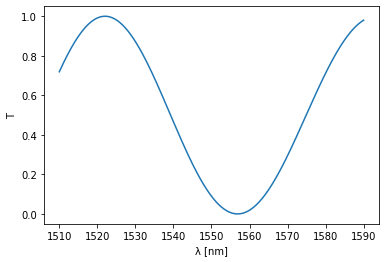

In [19]:
plt.plot(params["top"]["wl"] * 1e3, abs(S["in0", "out0"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.show()

## Optimization

We'd like to optimize an MZI such that one of the minima is at 1550nm. To do this, we need to define a loss function for the circuit at 1550nm. This function should take the parameters that you want to optimize as positional arguments:

In [20]:
@jax.jit
def loss(delta_length):
    params = sax.set_params(sax.get_params(mzi), wl=1.55)
    params["top"]["length"] = 15.0 + delta_length
    params["btm"]["length"] = 15.0
    params["lft"]["coupling"] = 0.5
    params["rgt"]["coupling"] = 0.5
    S = mzi(**params)
    return (abs(S["in0", "out0"]) ** 2).mean()

In [21]:
%time loss(10.)

CPU times: user 3.27 s, sys: 14.1 ms, total: 3.29 s
Wall time: 3.29 s


DeviceArray(0.08961975, dtype=float32)

We can use this loss function to define a grad function which works on the parameters of the loss function:

In [22]:
grad = jax.jit(
    jax.grad(
        loss,
        argnums=0,  # JAX gradient function for the first positional argument, jitted
    )
)

Next, we need to define a JAX optimizer, which on its own is nothing more than three more functions:  an initialization function with which to initialize the optimizer state, an update function which will update the optimizer state (and with it the model parameters). The third function that's being returned will give the model parameters given the optimizer state.

In [23]:
initial_delta_length = 10.0
optim_init, optim_update, optim_params = opt.adam(step_size=0.1)
optim_state = optim_init(initial_delta_length)

Given all this, a single training step can be defined:

In [24]:
def train_step(step, optim_state):
    params = optim_params(optim_state)
    lossvalue = loss(params)
    gradvalue = grad(params)
    optim_state = optim_update(step, gradvalue, optim_state)
    return lossvalue, optim_state


And we can use this step function to start the training of the MZI:

In [25]:
range_ = tqdm.trange(300)
for step in range_:
    lossvalue, optim_state = train_step(step, optim_state)
    range_.set_postfix(loss=f"{lossvalue:.6f}")


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.55it/s, loss=0.000000]


In [26]:
delta_length = optim_params(optim_state)
delta_length

DeviceArray(9.9359, dtype=float32)

Let's see what we've got over a range of wavelengths:

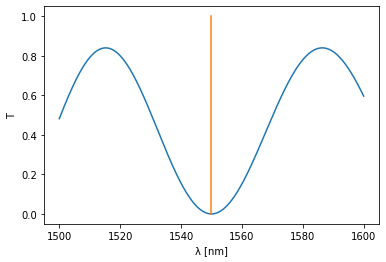

In [27]:
params = sax.set_params(sax.get_params(mzi), wl=jnp.linspace(1.5, 1.6, 1000))
params["top"]["length"] = 15.0 + delta_length
params["btm"]["length"] = 15.0
S = mzi(**params)
plt.plot(params["top"]["wl"] * 1e3, abs(S["in1", "out1"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.ylim(-0.05, 1.05)
plt.plot([1550, 1550], [0, 1])
plt.show()

The minimum of the MZI is perfectly located at 1550nm.

## MZI Chain

Let's now create a chain of MZIs. For this, we first create a subcomponent: a directional coupler with arms:


```
                             top
                         in ----- out -> out2
    in2 <- p3        p2                 
             \  dc  /                  
              ======                  
             /      \                
    in1 <- p0        p1      btm    
                         in ----- out -> out1
```

In [28]:
dc_with_arms = sax.circuit(
    instances={
        "lft": coupler,
        "top": waveguide,
        "btm": waveguide,
    },
    connections={
        "lft:out0": "btm:in0",
        "lft:out1": "top:in0",
    },
    ports={
        "in0": "lft:in0",
        "in1": "lft:in1",
        "out0": "btm:out0",
        "out1": "top:out0",
    },
)

An MZI chain can now be created by cascading these directional couplers with arms:

```
      _    _    _    _             _    _  
    \/   \/   \/   \/     ...    \/   \/   
    /\_  /\_  /\_  /\_           /\_  /\_  
```

In [29]:
def mzi_chain(num_mzis=1) -> sax.Model:
    chain = sax.circuit(
        instances={f"dc{i}": dc_with_arms for i in range(num_mzis + 1)},
        connections={
            **{f"dc{i}:out0": f"dc{i+1}:in0" for i in range(num_mzis)},
            **{f"dc{i}:out1": f"dc{i+1}:in1" for i in range(num_mzis)},
        },
        ports={
            "in0": f"dc0:in1",
            "in1": f"dc0:in2",
            "out0": f"dc{num_mzis}:out1",
            "out1": f"dc{num_mzis}:out2",
        },
    )
    return chain

Let's for example create a chain with 15 MZIs:

In [30]:
chain = mzi_chain(num_mzis=15)
params = sax.get_params(chain)
for dc in params:
    params[dc]["top"]["length"] = 25.0
    params[dc]["btm"]["length"] = 15.0
params = sax.set_params(params, wl=jnp.linspace(1.5, 1.6, 1000))

We can simulate this:

In [31]:
%time S = chain(**params) # time to evaluate the MZI
func = jax.jit(chain)
%time S = func(**params) # time to jit the MZI
%time S = func(**params) # time to evaluate the MZI after jitting

CPU times: user 1.07 s, sys: 21.2 ms, total: 1.09 s
Wall time: 1.07 s
CPU times: user 2min 5s, sys: 443 ms, total: 2min 5s
Wall time: 2min 5s
CPU times: user 35.4 ms, sys: 8 ms, total: 43.4 ms
Wall time: 25.7 ms


Where we see that the unjitted evaluation of the MZI chain takes about a second, while the jitting of the MZI chain takes about a minute (on a CPU). However, after the MZI chain has been jitted, the evaluation is in the order of about a millisecond!

Anyway, let’s see what this gives:

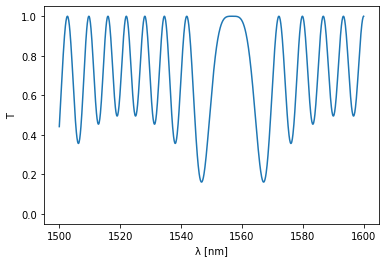

In [32]:
plt.plot(1e3 * params["dc0"]["top"]["wl"], jnp.abs(S["in0", "out0"]) ** 2)
plt.ylim(-0.05, 1.05)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

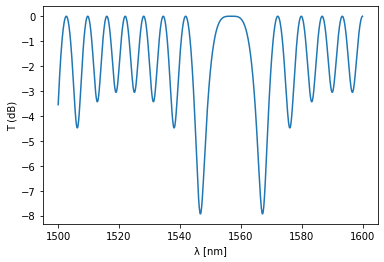

In [36]:
plt.plot(1e3 * params["dc0"]["top"]["wl"], 10*jnp.log10(jnp.abs(S["in0", "out0"]) ** 2))
plt.xlabel("λ [nm]")
plt.ylabel("T (dB)")
plt.show()